<a href="https://colab.research.google.com/github/Mostaq27/-Agroecological_Principles-_with-_AI-_for-_Crop-_Recommendation/blob/main/inferential_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kendalltau
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Crop recommendation dataset.csv")

print("Original shape :", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Original shape : (57000, 23)

First 5 rows:
  CROPS TYPE_OF_CROP           SOIL  SEASON SOWN HARVESTED WATER_SOURCE  \
0  rice      cereals  Alluvial soil  kharif  Jun       Sep    irrigated   
1  rice      cereals     Loamy soil  kharif  Jul       Oct      rainfed   
2  rice      cereals      Clay soil  kharif  Jun       Sep    irrigated   
3  rice      cereals  Alluvial soil  kharif  Jul       Oct      rainfed   
4  rice      cereals     Loamy soil  kharif  Jun       Sep    irrigated   

   SOIL_PH  SOIL_PH_HIGH  CROPDURATION  ...  WATERREQUIRED  WATERREQUIRED_MAX  \
0      7.6           8.0         116.9  ...         2462.3               2500   
1      6.2           8.0         117.9  ...         1237.5               2500   
2      6.7           8.0         117.7  ...         1075.1               2500   
3      6.1           8.0         149.8  ...         1549.9               2500   
4      8.0           8.0         131.7  ...         1306.4               2500   

   RELATIVE_HUMIDI

In [3]:
# 2. Keep only numeric columns for statistical analysis

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_num = df[numeric_cols].copy()

print("\nNumeric columns used :", numeric_cols)
print("Numeric data shape   :", df_num.shape)


Numeric columns used : ['SOIL_PH', 'SOIL_PH_HIGH', 'CROPDURATION', 'CROPDURATION_MAX', 'TEMP', 'MAX_TEMP', 'WATERREQUIRED', 'WATERREQUIRED_MAX', 'RELATIVE_HUMIDITY', 'RELATIVE_HUMIDITY_MAX', 'N', 'N_MAX', 'P', 'P_MAX', 'K', 'K_MAX']
Numeric data shape   : (57000, 16)


In [4]:
# 3. Basic inferential statistics

desc = df_num.describe().T
desc['skew']   = stats.skew(df_num, nan_policy='omit')
desc['kurt']   = stats.kurtosis(df_num, nan_policy='omit')
desc['var']    = df_num.var()
desc['std_err']= df_num.sem()                     # standard error of the mean
desc = desc.round(4)

print("\n=== Descriptive + Inferential Summary ===")
print(desc)


=== Descriptive + Inferential Summary ===
                         count       mean       std    min      25%     50%  \
SOIL_PH                57000.0     6.6244    0.6500    5.0    6.200     6.6   
SOIL_PH_HIGH           57000.0     7.2456    0.6093    6.0    6.800     7.0   
CROPDURATION           57000.0   109.3475   52.9314   21.0   75.900    99.9   
CROPDURATION_MAX       57000.0   117.7368   54.9341   21.0   90.000   105.0   
TEMP                   57000.0    24.7577    5.8625    5.0   21.100    24.8   
MAX_TEMP               57000.0    30.3860    6.3544   18.0   27.000    30.0   
WATERREQUIRED          57000.0   887.2629  356.3265  330.0  604.600   929.5   
WATERREQUIRED_MAX      57000.0  1038.5965  438.1036  350.0  750.000  1000.0   
RELATIVE_HUMIDITY      57000.0    71.1976   23.1586   15.0   64.400    78.2   
RELATIVE_HUMIDITY_MAX  57000.0    76.4211   23.8609   18.0   70.000    85.0   
N                      57000.0    81.2843   33.7862   20.0   56.600    80.5   
N_MAX    

In [6]:
# 4. Correlation matrices (Pearson, Spearman, Kendall)

corr_pearson  = df_num.corr(method='pearson')
corr_spearman = df_num.corr(method='spearman')
corr_kendall  = df_num.corr(method='kendall')

In [10]:
# 5. Pair-wise p-values for Pearson (example – you can do the same for others)

def pearson_pval(x, y):
    """Return Pearson r and p-value for two series."""
    # Convert numpy arrays to pandas Series to use dropna()
    x_series = pd.Series(x)
    y_series = pd.Series(y)
    r, p = pearsonr(x_series.dropna(), y_series.dropna())
    return pd.Series([r, p], index=['r', 'p'])

# Build a DataFrame with r and p
pearson_df = df_num.corr(method=lambda x, y: pearson_pval(x, y)['r'])
pval_df    = df_num.corr(method=lambda x, y: pearson_pval(x, y)['p'])

# Mask non-significant (p > 0.05) – optional
sig_mask = pval_df < 0.05
pearson_sig = pearson_df.where(sig_mask, other=np.nan)

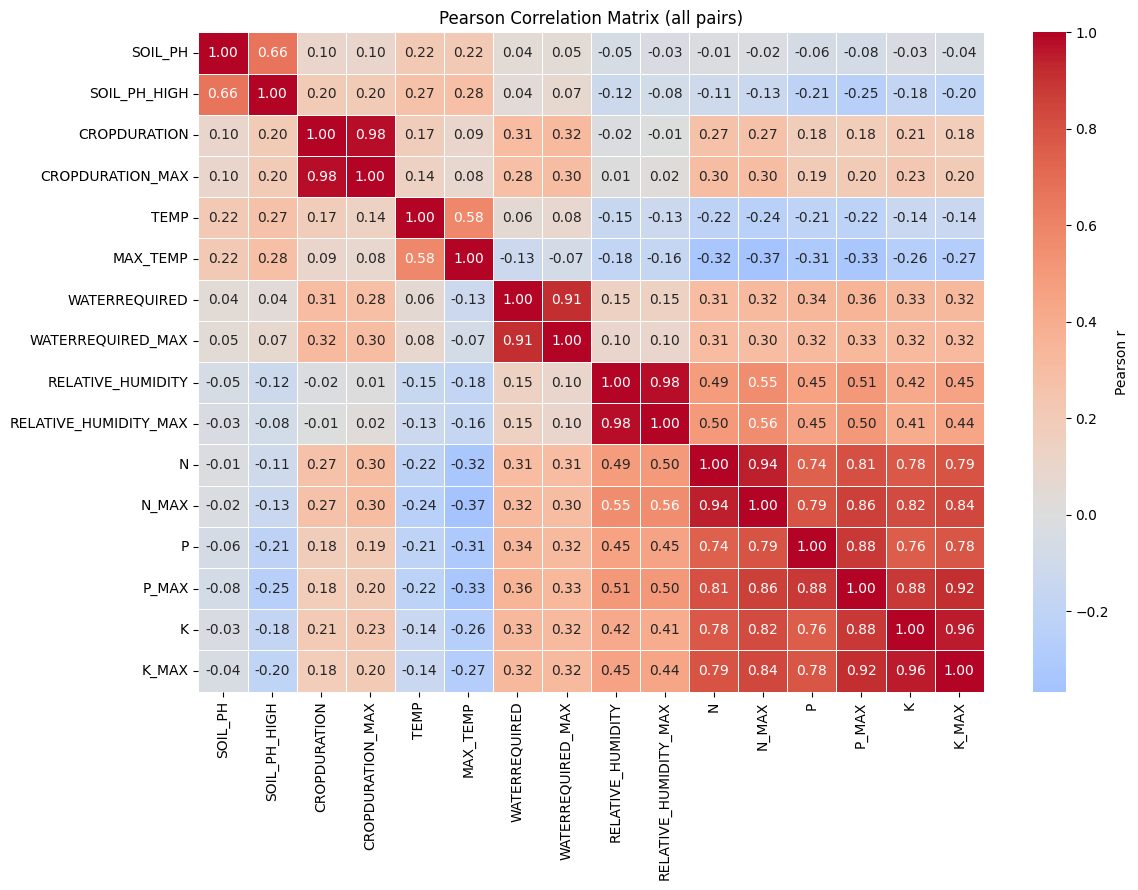

In [11]:
# 6. Visualise the Pearson correlation matrix (with significance)

plt.figure(figsize=(12, 9))
sns.heatmap(corr_pearson,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            center=0,
            linewidths=.5,
            cbar_kws={'label': 'Pearson r'})
plt.title("Pearson Correlation Matrix (all pairs)")
plt.tight_layout()
plt.show()

In [12]:
# 7. Print a tidy table of significant Pearson correlations

# Melt the matrix
melted = corr_pearson.stack().reset_index()
melted.columns = ['Var1', 'Var2', 'Pearson_r']
melted = melted[melted['Var1'] != melted['Var2']].copy()

# Add p-values
p_melted = pval_df.stack().reset_index()
p_melted.columns = ['Var1', 'Var2', 'p_value']
tidy_corr = pd.merge(melted, p_melted, on=['Var1','Var2'])

# Keep only significant (p < 0.05) and sort by absolute correlation
tidy_corr['abs_r'] = tidy_corr['Pearson_r'].abs()
tidy_corr = tidy_corr[tidy_corr['p_value'] < 0.05].sort_values('abs_r', ascending=False)

print("\n=== Significant Pearson Correlations (p < 0.05) ===")
print(tidy_corr[['Var1','Var2','Pearson_r','p_value']].round(4).to_string(index=False))


=== Significant Pearson Correlations (p < 0.05) ===
                 Var1                  Var2  Pearson_r  p_value
    RELATIVE_HUMIDITY RELATIVE_HUMIDITY_MAX     0.9789   0.0000
RELATIVE_HUMIDITY_MAX     RELATIVE_HUMIDITY     0.9789   0.0000
         CROPDURATION      CROPDURATION_MAX     0.9776   0.0000
     CROPDURATION_MAX          CROPDURATION     0.9776   0.0000
                    K                 K_MAX     0.9556   0.0000
                K_MAX                     K     0.9556   0.0000
                N_MAX                     N     0.9442   0.0000
                    N                 N_MAX     0.9442   0.0000
                K_MAX                 P_MAX     0.9197   0.0000
                P_MAX                 K_MAX     0.9197   0.0000
        WATERREQUIRED     WATERREQUIRED_MAX     0.9150   0.0000
    WATERREQUIRED_MAX         WATERREQUIRED     0.9150   0.0000
                P_MAX                     P     0.8842   0.0000
                    P                 P_MAX     0.8

In [13]:
# 8. Optional: Full Spearman / Kendall tables (same style)

print("\nSpearman correlation (top 10 strongest):")
print(corr_spearman.abs().unstack().sort_values(ascending=False)
      .drop_duplicates().head(10))

print("\nKendall correlation (top 10 strongest):")
print(corr_kendall.abs().unstack().sort_values(ascending=False)
      .drop_duplicates().head(10))


Spearman correlation (top 10 strongest):
SOIL_PH            SOIL_PH                  1.000000
P_MAX              K_MAX                    0.962655
CROPDURATION       CROPDURATION_MAX         0.954836
K                  K_MAX                    0.952693
N_MAX              N                        0.936429
RELATIVE_HUMIDITY  RELATIVE_HUMIDITY_MAX    0.931483
K                  P_MAX                    0.922388
WATERREQUIRED_MAX  WATERREQUIRED            0.903296
P_MAX              P                        0.873024
K_MAX              N_MAX                    0.867347
dtype: float64

Kendall correlation (top 10 strongest):
SOIL_PH            SOIL_PH                  1.000000
P_MAX              K_MAX                    0.921518
CROPDURATION       CROPDURATION_MAX         0.864594
K                  K_MAX                    0.839823
N_MAX              N                        0.827917
RELATIVE_HUMIDITY  RELATIVE_HUMIDITY_MAX    0.815311
K                  P_MAX                    0.789623
K

In [14]:
# 9. Save results (optional)

desc.to_csv("descriptive_inferential_summary.csv")
tidy_corr.to_csv("significant_pearson_correlations.csv", index=False)

print("\nAll done! Files saved: descriptive_inferential_summary.csv, significant_pearson_correlations.csv")


All done! Files saved: descriptive_inferential_summary.csv, significant_pearson_correlations.csv
